The invoice_lines folder contains a pickled Pandas data frame with over 150,000 rows derived from invoices. Each row in this data frame contains the text of the line and the category to which the line belongs (1 = line-item, 0 = everything else). The goal of this task is to create a Bag of Words classifier with sklearn that can classify these lines. The first step here is to divide the dataset into a train and test set. The script you write should give as output the precision / recall / accuracy scores on this test set. You can find the files here:


## Prepare all the needed libraries

In [1]:
import numpy as np
import pandas as pd
import pickle
import string
import sklearn 
from matplotlib import pyplot
import numpy as np
%matplotlib inline

from sklearn.model_selection import train_test_split
import re  # regex 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk  
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support as score



##### To extract information from a text using machine learning, there are muliple steps should be done to the text before applying the machine learning. 

###### These steps are shown in the following picture. 
* Clean the text 
* Extract features 
* finally applying machine learning 

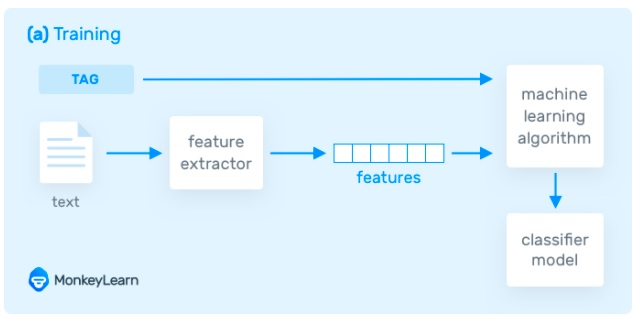


In [2]:
# Read pickled data using pandas 

unpickled_df = pd.read_pickle("invoice_lines.pkl")
unpickled_df.head()

,text,labels
0,LANDHAUS & HOTEL,0
1,WASTANIE,0
2,"KASTANIE, SPECKSAALREDDER 14, 22397 HAMBURG",0
3,HACO LAADKLEPPEN SERVICE BV,0
4,LAAN VAN DE RAM 11,0


In [3]:
np.shape(unpickled_df)

(153050, 2)

### NLP first steps is to clean data using the following techniques:

* Tokenization.(segmet the text)

* Lower casing.( to avoid case sensetive, convert all capital letters into small letters.)

* Stop words removal.( removing all the stop words such as the auxiliary verbs(is, am), articles(a,an) etc...

* Stemming.(return all the word to its stem (eg. learning-> learn, cats-> cat)

* Lemmatization( is similar to stemming but it brings context to the words. So it links words with similar meaning to one word.)



### Read in & clean text

### Tokenize text/ remove punctuation/ Convert words to lower case/ 

In [4]:
stopwords = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()
######################################################################################################
# This function remove punctuation, convert all uppercase to lower case and finally segment word     # 
######################################################################################################

def tokenize_data(text_list):

    LowerCase= "".join([word.lower() for word in text_list if word not in string.punctuation])
    tokenized_item=re.split('\W+', LowerCase)
    text = [ps.stem(word) for word in tokenized_item if word not in stopwords]
    
    return (text)


In [5]:
# string.punctuation

In [6]:
#########################################################################################################
# Extract features from the text such as how frequent words mentioned in text, and the text length etc..#
#########################################################################################################

# A function to count number of words in each text in the data frame 


def word_freq(text): 
    word_freq_list=[]
    for row in text:
        word_count=0
        for word in row.split():
            if word not in string.punctuation:
                word_count+=1
        if (len(row.split()) - row.count(" "))==0:
            word_freq=0
        else:
            word_freq=round(word_count/(abs(len(row.split()) - row.count(" "))))
        word_freq_list.append(word_freq)
    return word_freq_list
   


def len_text(text):
    len_text_list=[]
    for row in text:
        len_text_list.append(abs(len(row.split())))
    return len_text_list

In [7]:
unpickled_df['word_freq%'] = word_freq(unpickled_df['text'])
unpickled_df['len_text'] = len_text(unpickled_df['text'])

In [8]:
# concatenate all the data frames in one data frame 
unpickled_df_new= pd.concat([unpickled_df['text'],unpickled_df['len_text'],unpickled_df['word_freq%'] ,unpickled_df['labels']], axis=1)

In [9]:
## Test the functions
Sample= unpickled_df['text'][:5]
print(word_freq(Sample))
print(len_text(Sample))

[2, 1, 5, 4, 5]
[3, 1, 5, 4, 5]


In [10]:
unpickled_df_new

,text,len_text,word_freq%,labels
0,LANDHAUS & HOTEL,3,2,0
1,WASTANIE,1,1,0
2,"KASTANIE, SPECKSAALREDDER 14, 22397 HAMBURG",5,5,0
3,HACO LAADKLEPPEN SERVICE BV,4,4,0
4,LAAN VAN DE RAM 11,5,5,0
...,...,...,...,...
153045,30-06 11:55 - 12:05 Transactiekosten - Mobie...,8,6,0
153046,Smallingerland 00:09:21 ...,4,0,0
153047,"TOTAAL € 11,43",3,0,0
153048,Parkmobile B.V. Wisselwerking 40 | 1112 XR Die...,16,15,0


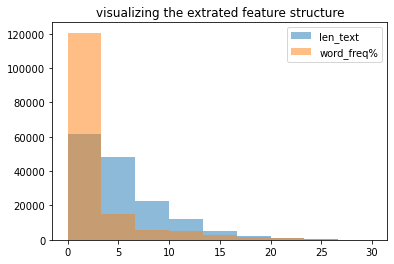

In [11]:
## Visualize the extracted features struture 


bins = np.linspace(0, 30, 10)

pyplot.hist(unpickled_df['len_text'], bins,label='len_text',alpha=0.5)
pyplot.hist(unpickled_df['word_freq%'], bins, label='word_freq%', alpha=0.5)
pyplot.title("visualizing the extrated feature structure")
pyplot.legend()

pyplot.show()

####  It is important to transform skeuwed data into gaussian like shape. since the model  will be less likely to successfully predict . The concept is the same as training a model on imbalanced categorical classes. If the values of a certain independent variable (feature) are skewed, depending on the model, skewness may violate model assumptions (e.g. logistic regression) or may impair the interpretation of feature importance.


## Vectorize Tokenized data ( making bag of words)

In [28]:
# Split data into train and test 
X_train, X_test, y_train, y_test = train_test_split(unpickled_df_new.drop(columns=['labels'])[:10000], unpickled_df['labels'][:10000], test_size=0.2)

In [29]:
print(np.shape(X_train))
print(np.shape(y_train))

(8000, 3)
(8000,)


#####  Important to know:
I tried to process all the data, unfortanately my laptop could not do that. 
So I just used 2000 as input to the model 

## Apply TfidfVectorizer

In [30]:
#############################################################################################
## Convert a collection of raw documents to a matrix of TF-IDF features.                    #
# TF-IDF are word frequency scores that try to highlight words that are more interesting    #
#############################################################################################

tfidf_vect = TfidfVectorizer(analyzer=tokenize_data)# analyzer calls the function defined up to tokenize raw data
                                                    
tfidf_vect_fit = tfidf_vect.fit(X_train['text'])

tfidf_train = tfidf_vect_fit.transform(X_train['text'])
tfidf_test = tfidf_vect_fit.transform(X_test['text'])

In [31]:
# print(tfidf_vect.get_feature_names())
print(np.shape(tfidf_vect.get_feature_names()))
print(np.shape(tfidf_train))
print(type(tfidf_train))

(10898,)
(8000, 10898)
<class 'scipy.sparse.csr.csr_matrix'>


In [32]:
# Combine additional data to my TFIDF array

X_train_vect = pd.concat([X_train.drop(columns=['text']).reset_index(drop=True), 
           pd.DataFrame(tfidf_train.toarray())], axis=1)

X_test_vect = pd.concat([X_test.drop(columns=['text']).reset_index(drop=True), 
           pd.DataFrame(tfidf_test.toarray())], axis=1)

In [33]:
# X_train_vect

In [34]:
#########################################################################################
# Use the extracted features for prediction using one of machine learning models.       #
#########################################################################################

# Any machine learning classifier can be used.
# Here I used RandomForestClassifier 

rf = RandomForestClassifier(n_estimators=150, max_depth=None, n_jobs=-1)

rf_model = rf.fit(X_train_vect, y_train)

# predicted labels 
y_pred = rf_model.predict(X_test_vect)



## This scores is not reliable, since I'm using a sub-set  from the whole data set. As I mentioned before I couldn't process all the data set. 

In [36]:
# Evaluation metrics to evaluate the model 
# y_true = np.array(['cat', 'dog', 'pig', 'cat', 'dog', 'pig'])
# y_pred = np.array(['cat', 'pig', 'dog', 'cat', 'cat', 'dog'])
precision, recall, fscore,_= score(y_test, y_pred, average='weighted')
print(" Precision: {}, recall: {} , fscore: {}".format(precision, recall, fscore))

precision, recall, fscore,_= score(y_test, y_pred, average='micro')
print(" Precision: {}, recall: {} , fscore: {}".format(precision, recall, fscore))



 Precision: 0.9070951876513317, recall: 0.915 , fscore: 0.9012993667459808
 Precision: 0.915, recall: 0.915 , fscore: 0.915


### Helpful resources

1) [Text Classification](https://monkeylearn.com/text-classification/#:~:text=Some%20of%20the%20most%20popular,SVM)%2C%20and%20deep%20learning.)

2) [pandas.read_pickle](https://pandas.pydata.org/docs/reference/api/pandas.read_pickle.html)

3) [Stemming vs Lemmatization When Using Python](https://pdf.co/blog/stemming-vs-lemmatization-using-python)

4) [Natural Language Processing (NLP) Simplified : A Step-by-step Guide](https://datascience.foundation/sciencewhitepaper/natural-language-processing-nlp-simplified-a-step-by-step-guide)

5) [How to count the number of characters in a string except spaces in Python](https://www.kite.com/python/answers/how-to-count-the-number-of-characters-in-a-string-except-spaces-in-python#:~:text=Use%20len(object)%20to%20get,get%20the%20number%20of%20letters.)

6) [Transforming Skewed Data for Machine Learning](https://opendatascience.com/transforming-skewed-data-for-machine-learning/)

7) [The Bag of Words representation](https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)

8) [Combine additional data to my TFIDF array](https://stackoverflow.com/questions/61827301/combine-additional-data-to-my-tfidf-array)
 
9) [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

10) [Text feature extraction](https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
